<a href="https://colab.research.google.com/github/JSchweisthal/ImPULSeS/blob/main/simclr_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
import torch
import torch.nn as nn
import torchvision
import numpy as np

In [4]:
!git clone https://github.com/JSchweisthal/SimCLR.git
%cd SimCLR

Cloning into 'SimCLR'...
remote: Enumerating objects: 926, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 926 (delta 252), reused 271 (delta 133), pack-reused 527
Receiving objects: 100% (926/926), 379.40 KiB | 4.93 MiB/s, done.
Resolving deltas: 100% (544/544), done.
/content/SimCLR


In [5]:
from model import save_model, load_optimizer
from simclr import SimCLR
from simclr.modules import get_resnet, NT_Xent
from simclr.modules.transformations import TransformsSimCLR

In [44]:
class Empty():
    pass

args = Empty() 
args.batch_size = 64
args.dataset = "CIFAR10" # make sure to check this with the (pre-)trained checkpoint
args.resnet = "resnet50" # make sure to check this with the (pre-)trained checkpoint
args.model_path = "logs"
args.epoch_num = 100
args.logistic_epochs = 90
args.seed = 1234
args.dataset_dir = "dataset"
args.image_size = 224
args.data_pretrain = "imbalanced"
args.data_classif = "10class"
args.nodes = 1
args.workers = 4
args.logistic_batch_size = 256
args.device = torch.device("cuda")

In [29]:
def inference(loader, simclr_model, device, dataset, maxlen_loader=1000000):
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)

        # get encoding
        with torch.no_grad():
            h, _, z, _ = simclr_model(x, x)

        h = h.detach()

        feature_vector.extend(h.cpu().detach().numpy())
        labels_vector.extend(y.numpy())

        if step % 10 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
        
        if step>=(maxlen_loader-1):
            break

    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector


def get_features(context_model, train_loader, test_loader, device, dataset, maxlen_loaders=[10000, 10000]):
    train_X, train_y = inference(train_loader, context_model, device, dataset, maxlen_loaders[0])
    test_X, test_y = inference(test_loader, context_model, device, dataset, maxlen_loaders[1])
    return train_X, train_y, test_X, test_y


def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test, batch_size):
    train = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train), torch.from_numpy(y_train)
    )
    train_loader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=False
    )

    test = torch.utils.data.TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test)
    )
    test_loader = torch.utils.data.DataLoader(
        test, batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader

In [42]:
if args.dataset == "STL10":
    train_dataset = torchvision.datasets.STL10(
        args.dataset_dir,
        split="train",
        download=True,
        transform=TransformsSimCLR(size=args.image_size).test_transform,
    )
    test_dataset = torchvision.datasets.STL10(
        args.dataset_dir,
        split="test",
        download=True,
        transform=TransformsSimCLR(size=args.image_size).test_transform,
    )
elif args.dataset == "CIFAR100":
    train_dataset = torchvision.datasets.CIFAR100(
        args.dataset_dir,
        train=True,
        download=True,
        transform=TransformsSimCLR(size=args.image_size).test_transform,
    )
    test_dataset = torchvision.datasets.CIFAR100(
        args.dataset_dir,
        train=False,
        download=True,
        transform=TransformsSimCLR(size=args.image_size).test_transform,
    )
    if args.data_pretrain == "imbalanced":
        idxs = []
        idxtargets_up = []
        for cls in range(100):
            idxs_cls = [i for i in range(len(train_dataset.targets)) if train_dataset.targets[i]==cls]
            if cls not in [23]: # cloud, keep this size and shrink all other classes to 20 %
                if args.data_pretrain == "imbalanced":
                    idxs_cls = idxs_cls[:int(len(idxs_cls) * 0.2)]
            idxs.extend(idxs_cls)
            idxs.sort()
        idxtargets_up = torch.tensor(idxtargets_up)
        train_dataset.targets = torch.tensor(train_dataset.targets)
        train_datasubset_pu = torch.utils.data.Subset(train_dataset, idxs)
elif args.dataset == "CIFAR10":
    train_dataset = torchvision.datasets.CIFAR10(
        args.dataset_dir,
        train=True,
        download=True,
        transform=TransformsSimCLR(size=args.image_size).test_transform,
    )
    test_dataset = torchvision.datasets.CIFAR10(
        args.dataset_dir,
        train=False,
        download=True,
        transform=TransformsSimCLR(size=args.image_size).test_transform,
    )

    if args.data_pretrain == "imbalanced" or args.data_classif == "PU":
        idxs = []
        idxtargets_up = []
        for cls in range(10):
            idxs_cls = [i for i in range(len(train_dataset.targets)) if train_dataset.targets[i]==cls]
            if cls in [0, 1, 8, 9]:
                if args.data_pretrain == "imbalanced":
                    idxs_cls = idxs_cls[:750]
                if args.data_classif == "PU":  
                    idxtargets_up_cls = idxs_cls[:int((1-args.PU_ratio)*len(idxs_cls))] # change here 0.2 for any other prop of labeled positive / all positives
            idxs.extend(idxs_cls)
            idxs.sort()
            if args.data_classif == "PU":  
                idxtargets_up.extend(idxtargets_up_cls)
                idxtargets_up.sort()
        idxtargets_up = torch.tensor(idxtargets_up)

        train_dataset.targets = torch.tensor(train_dataset.targets)
        if args.data_classif == "PU":  
            train_dataset.targets[idxtargets_up] = 0
        train_datasubset_pu = torch.utils.data.Subset(train_dataset, idxs) 

else:
    raise NotImplementedError

if args.data_pretrain == "all":
        train_datasubset_pu = train_dataset

train_loader = torch.utils.data.DataLoader(
    train_datasubset_pu, #train_dataset,
    batch_size=args.logistic_batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=args.workers,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=args.logistic_batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=args.workers,
)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# balanced
path_simclr = '../gdrive/MyDrive/MA_private/models/baseSimCLR/checkpoint_200.tar'
encoder = get_resnet('resnet50', pretrained=False) # don't load a pre-trained model from PyTorch repo
n_features = encoder.fc.in_features  # get dimensions of fc layer
simclr_cifar10 = SimCLR(encoder, 128, n_features)
simclr_cifar10.load_state_dict(torch.load(path_simclr))
simclr_cifar10.to(torch.device('cuda'))

In [ ]:
# imbalanced
path_simclr = '../gdrive/MyDrive/MA_private/models/imbPUSimCLR/checkpoint_200.tar'
encoder = get_resnet('resnet50', pretrained=False) # don't load a pre-trained model from PyTorch repo
n_features = encoder.fc.in_features  # get dimensions of fc layer
simclr_cifar10_imb = SimCLR(encoder, 128, n_features)
simclr_cifar10_imb.load_state_dict(torch.load(path_simclr))
simclr_cifar10_imb.to(torch.device('cuda'))

In [176]:
# creating features once for finetuning
print("### Creating features from pre-trained context model ###")
(train_X, train_y, test_X, test_y) = get_features(
    simclr_cifar10, train_loader, test_loader, args.device, args.dataset#, maxlen_loaders=[19*4, 31*4] # like STL10
)

arr_train_loader, arr_test_loader = create_data_loaders_from_arrays(
    train_X, train_y, test_X, test_y, args.logistic_batch_size
)

### Creating features from pre-trained context model ###


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Step [0/128]	 Computing features...
Step [10/128]	 Computing features...
Step [20/128]	 Computing features...
Step [30/128]	 Computing features...
Step [40/128]	 Computing features...
Step [50/128]	 Computing features...
Step [60/128]	 Computing features...
Step [70/128]	 Computing features...
Step [80/128]	 Computing features...
Step [90/128]	 Computing features...
Step [100/128]	 Computing features...
Step [110/128]	 Computing features...
Step [120/128]	 Computing features...
Features shape (32768, 2048)
Step [0/39]	 Computing features...
Step [10/39]	 Computing features...
Step [20/39]	 Computing features...
Step [30/39]	 Computing features...
Features shape (9984, 2048)


In [179]:
# creating features once for finetuning
print("### Creating features from pre-trained context model ###")
(train_X, train_y, test_X, test_y) = get_features(
    simclr_cifar10_imb, train_loader, test_loader, args.device, args.dataset#, maxlen_loaders=[19*4, 31*4] # like STL10
)

arr_train_loader_imb, arr_test_loader_imb = create_data_loaders_from_arrays(
    train_X, train_y, test_X, test_y, args.logistic_batch_size
)

### Creating features from pre-trained context model ###


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Step [0/128]	 Computing features...
Step [10/128]	 Computing features...
Step [20/128]	 Computing features...
Step [30/128]	 Computing features...
Step [40/128]	 Computing features...
Step [50/128]	 Computing features...
Step [60/128]	 Computing features...
Step [70/128]	 Computing features...
Step [80/128]	 Computing features...
Step [90/128]	 Computing features...
Step [100/128]	 Computing features...
Step [110/128]	 Computing features...
Step [120/128]	 Computing features...
Features shape (32768, 2048)
Step [0/39]	 Computing features...
Step [10/39]	 Computing features...
Step [20/39]	 Computing features...
Step [30/39]	 Computing features...
Features shape (9984, 2048)


In [253]:
def calc_covcor(loader):

    cov_dict = {}
    cor_dict = {}
    for label in range(0, 10):
        features = torch.tensor([])
        for batch in loader:
            feats_label = batch[0][batch[1] == label]
            features = torch.cat((features, feats_label))
        cov_dict[label] = torch.cov(features.T) # [:740]
        cor_dict[label] = torch.corrcoef(features.T)
    return cov_dict, cor_dict

# if changed to equal size per class, covsum for minor classes a bit higher 
# tendecially, else much lower!

In [265]:
cov_dict, _ = calc_covcor(arr_test_loader)
cov_dict_imb, _ = calc_covcor(arr_test_loader_imb)
covsum_dict = {k: torch.sum(torch.diag(v)).round() for k, v in cov_dict.items()}
covsum_dict_imb = {k: torch.sum(torch.diag(v)).round() for k, v in cov_dict_imb.items()}

In [267]:
covsum_dict, covsum_dict_imb

({0: tensor(328.),
  1: tensor(395.),
  2: tensor(368.),
  3: tensor(408.),
  4: tensor(329.),
  5: tensor(462.),
  6: tensor(356.),
  7: tensor(417.),
  8: tensor(285.),
  9: tensor(285.)},
 {0: tensor(314.),
  1: tensor(312.),
  2: tensor(515.),
  3: tensor(540.),
  4: tensor(457.),
  5: tensor(622.),
  6: tensor(496.),
  7: tensor(605.),
  8: tensor(272.),
  9: tensor(230.)})

In [167]:
labels = torch.tensor([])
for batch in arr_train_loader:
    label = batch[1]
    labels = torch.cat((labels, label))

In [168]:
labels.unique(return_counts=True)

(tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 tensor([ 741,  743, 4970, 4969, 4956, 4963, 4973, 4962,  745,  746]))

In [362]:
def calc_avg_sim(loader):
    with torch.no_grad():
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        sim = {}
        class_vectors = torch.tensor([])
        for label in range(0, 10):
            features = torch.tensor([])
            for batch in loader:
                feats_label = batch[0][batch[1] == label]
                features = torch.cat((features, feats_label))
            mean_feat = features.mean(axis=0)
            class_vectors = torch.cat((class_vectors, mean_feat), axis=0)
            sim[label] = cos(features, mean_feat.repeat(len(features), 1)).mean() # no mean and then extract hard samples!
    return sim, class_vectors.reshape(-1, features.shape[1])

In [363]:
sim_bal, clsvec_bal = calc_avg_sim(arr_test_loader)

In [364]:
sim_imb, clsvec_imb = calc_avg_sim(arr_test_loader_imb)

In [365]:
sim_bal, sim_imb

({0: tensor(0.7808),
  1: tensor(0.8527),
  2: tensor(0.7537),
  3: tensor(0.7886),
  4: tensor(0.7948),
  5: tensor(0.8028),
  6: tensor(0.8060),
  7: tensor(0.8165),
  8: tensor(0.8172),
  9: tensor(0.8643)},
 {0: tensor(0.8006),
  1: tensor(0.8672),
  2: tensor(0.7860),
  3: tensor(0.8280),
  4: tensor(0.8291),
  5: tensor(0.8329),
  6: tensor(0.8307),
  7: tensor(0.8381),
  8: tensor(0.8292),
  9: tensor(0.8726)})

In [389]:
cos = nn.CosineSimilarity(dim=2, eps=1e-6)
with torch.no_grad():
    # cosmat = cos(clsvec_bal.expand(10, 10, 2048), clsvec_bal.expand(10, 10, 2048))
    cosmat_bal = cos(clsvec_bal.unsqueeze(0), clsvec_bal.unsqueeze(1))
    cosmat_imb = cos(clsvec_imb.unsqueeze(0), clsvec_imb.unsqueeze(1))

In [390]:
cosmat_bal.mean(axis=0), cosmat_imb.mean(axis=0)

(tensor([0.7590, 0.7371, 0.8203, 0.8144, 0.7927, 0.7929, 0.7500, 0.7848, 0.7253,
         0.7155]),
 tensor([0.8681, 0.8568, 0.8933, 0.8858, 0.8573, 0.8592, 0.8273, 0.8491, 0.8621,
         0.8481]))

In [428]:
cosmat_bal[:, [0, 1, 8, 9]][[0, 1, 8, 9]], cosmat_imb[:, [0, 1, 8, 9]][[0, 1, 8, 9]]

(tensor([[1.0000, 0.7150, 0.8292, 0.7147],
         [0.7150, 1.0000, 0.7150, 0.8357],
         [0.8292, 0.7150, 1.0000, 0.7134],
         [0.7147, 0.8357, 0.7134, 1.0000]]),
 tensor([[1.0000, 0.8795, 0.9542, 0.8566],
         [0.8795, 1.0000, 0.9165, 0.9508],
         [0.9542, 0.9165, 1.0000, 0.8865],
         [0.8566, 0.9508, 0.8865, 1.0000]]))

In [433]:
cosmat_bal[:, range(2, 8)][range(2, 8)], cosmat_imb[:, range(2, 8)][range(2, 8)]

(tensor([[1.0000, 0.9068, 0.8848, 0.8726, 0.8477, 0.8289],
         [0.9068, 1.0000, 0.8366, 0.9481, 0.8405, 0.8136],
         [0.8848, 0.8366, 1.0000, 0.8174, 0.8147, 0.8964],
         [0.8726, 0.9481, 0.8174, 1.0000, 0.7687, 0.8192],
         [0.8477, 0.8405, 0.8147, 0.7687, 1.0000, 0.7183],
         [0.8289, 0.8136, 0.8964, 0.8192, 0.7183, 1.0000]]),
 tensor([[1.0000, 0.9388, 0.9109, 0.9044, 0.8895, 0.8644],
         [0.9388, 1.0000, 0.8740, 0.9628, 0.8761, 0.8493],
         [0.9109, 0.8740, 1.0000, 0.8453, 0.8733, 0.9059],
         [0.9044, 0.9628, 0.8453, 1.0000, 0.8147, 0.8498],
         [0.8895, 0.8761, 0.8733, 0.8147, 1.0000, 0.7699],
         [0.8644, 0.8493, 0.9059, 0.8498, 0.7699, 1.0000]]))

In [434]:
cosmat_bal[:, [0, 1, 8, 9]][range(2, 8)], cosmat_imb[:, [0, 1, 8, 9]][range(2, 8)]

(tensor([[0.8013, 0.6955, 0.7017, 0.6640],
         [0.7264, 0.7114, 0.6855, 0.6755],
         [0.7084, 0.6727, 0.6608, 0.6355],
         [0.7085, 0.6887, 0.6576, 0.6484],
         [0.6485, 0.6448, 0.6196, 0.5966],
         [0.7380, 0.6922, 0.6705, 0.6714]]),
 tensor([[0.9147, 0.8355, 0.8673, 0.8075],
         [0.8488, 0.8376, 0.8357, 0.8350],
         [0.8077, 0.7752, 0.7962, 0.7845],
         [0.8184, 0.8004, 0.8012, 0.7949],
         [0.7691, 0.7726, 0.7667, 0.7413],
         [0.8318, 0.7994, 0.7969, 0.8236]]))

In [396]:
cosmat_bal

tensor([[1.0000, 0.7150, 0.8013, 0.7264, 0.7084, 0.7085, 0.6485, 0.7380, 0.8292,
         0.7147],
        [0.7150, 1.0000, 0.6955, 0.7114, 0.6727, 0.6887, 0.6448, 0.6922, 0.7150,
         0.8357],
        [0.8013, 0.6955, 1.0000, 0.9068, 0.8848, 0.8726, 0.8477, 0.8289, 0.7017,
         0.6640],
        [0.7264, 0.7114, 0.9068, 1.0000, 0.8366, 0.9481, 0.8405, 0.8136, 0.6855,
         0.6755],
        [0.7084, 0.6727, 0.8848, 0.8366, 1.0000, 0.8174, 0.8147, 0.8964, 0.6608,
         0.6355],
        [0.7085, 0.6887, 0.8726, 0.9481, 0.8174, 1.0000, 0.7687, 0.8192, 0.6576,
         0.6484],
        [0.6485, 0.6448, 0.8477, 0.8405, 0.8147, 0.7687, 1.0000, 0.7183, 0.6196,
         0.5966],
        [0.7380, 0.6922, 0.8289, 0.8136, 0.8964, 0.8192, 0.7183, 1.0000, 0.6705,
         0.6714],
        [0.8292, 0.7150, 0.7017, 0.6855, 0.6608, 0.6576, 0.6196, 0.6705, 1.0000,
         0.7134],
        [0.7147, 0.8357, 0.6640, 0.6755, 0.6355, 0.6484, 0.5966, 0.6714, 0.7134,
         1.0000]])

# Visualization Dim Reduction




In [102]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [169]:
# just select k batches (k * 256 random samples) for faster computation
def df_dimreduction(loader, num_batches = 999, do_pca=True, do_tsne=True):
    features = torch.tensor([])
    labels = torch.tensor([])
    i = 0
    for batch in loader:
        features = torch.cat((features, batch[0]))
        labels = torch.cat((labels, batch[1]))
        i += 1
        if i >= num_batches:
            break
    features = features.numpy()
    labels = labels.numpy()
    feat_cols = ['dim'+str(i) for i in range(features.shape[1]) ]
    df = pd.DataFrame(features,columns=feat_cols)
    df['y'] = labels
    df['label'] = df['y'].apply(lambda i: str(i))

    df['ybin'] = np.where(df['y'].isin([0, 1, 8, 9]), 1, 0)

    if do_pca:
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(df[feat_cols].values)
        df['pca-one'] = pca_result[:,0]
        df['pca-two'] = pca_result[:,1] 
        df['pca-three'] = pca_result[:,2]
        print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    
    if do_tsne:
        time_start = time.time()
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(df[feat_cols].values)
        print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
        df['tsne-2d-one'] = tsne_results[:,0]
        df['tsne-2d-two'] = tsne_results[:,1]

    return df

In [180]:
df_bal = df_dimreduction(arr_test_loader)

Explained variation per principal component: [0.12805977 0.09983925 0.07211496]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9984 samples in 0.016s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9984 samples in 8.938s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 5.687095
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.488747
[t-SNE] KL divergence after 300 iterations: 2.976694
t-SNE done! Time elapsed: 47.09976005554199 seconds


In [181]:
df_imb = df_dimreduction(arr_test_loader_imb)

Explained variation per principal component: [0.15823844 0.10191416 0.09724014]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9984 samples in 0.017s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 9984 samples in 8.483s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9984
[t-SNE] Computed conditional probabilities for sample 2000 / 9984
[t-SNE] Computed conditional probabilities for sample 3000 / 9984
[t-SNE] Computed conditional probabilities for sample 4000 / 9984
[t-SNE] Computed conditional probabilities for sample 5000 / 9984
[t-SNE] Computed conditional probabilities for sample 6000 / 9984
[t-SNE] Computed conditional probabilities for sample 7000 / 9984
[t-SNE] Computed conditional probabilities for sample 8000 / 9984
[t-SNE] Computed conditional probabilities for sample 9000 / 9984
[t-SNE] Computed conditional probabilities for sample 9984 / 9984
[t-SNE] Mean sigma: 5.742292
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.303078
[t-SNE] KL divergence after 300 iterations: 3.209479
t-SNE done! Time elapsed: 41.610766887664795 seconds


In [225]:
def idx_to_class(idx):
    lkp = {v: k for k, v in test_dataset.class_to_idx.items()}
    return lkp[idx]

for df in [df_bal, df_imb]:
    df.loc[:, 'class'] = df['y'].apply(idx_to_class)

In [184]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df_bal.shape[0])

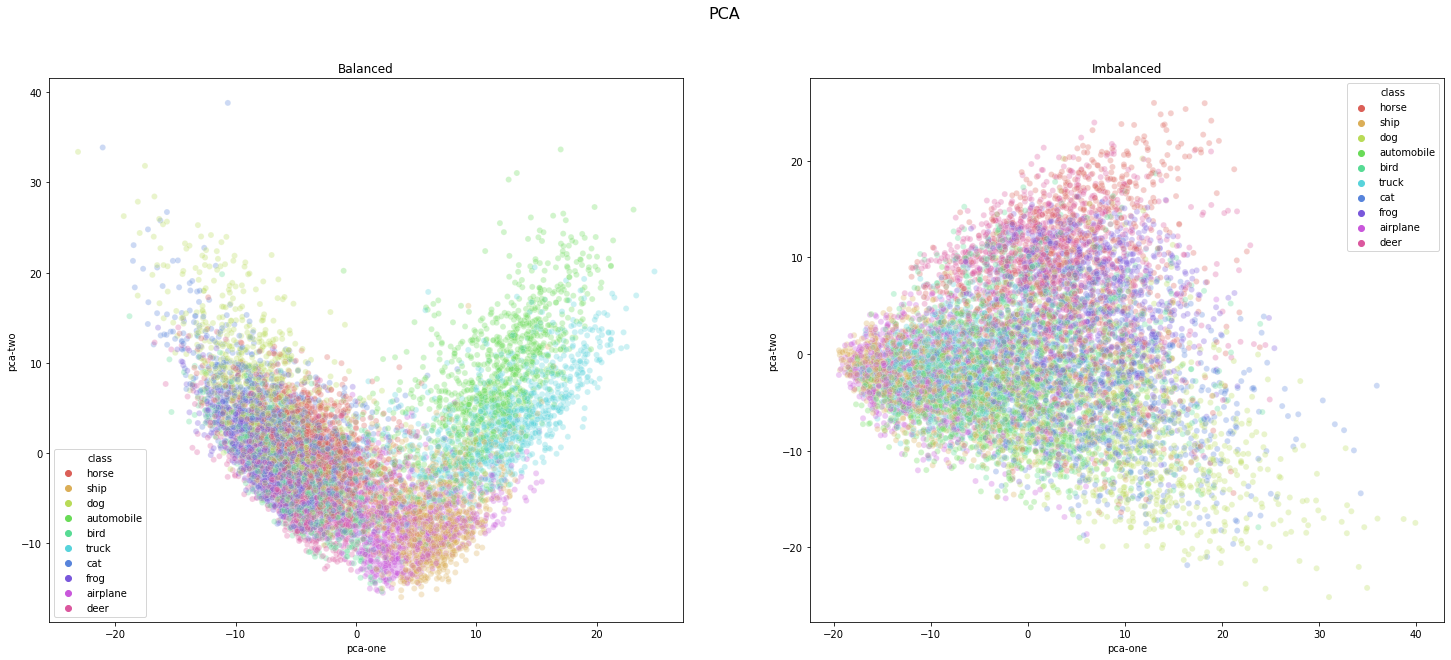

In [226]:
f = plt.figure(figsize=(25,10))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="class",# "y", # "ybin"
    palette=sns.color_palette("hls", 10), # 2
    data=df_bal.loc[rndperm,:],
    legend="full",
    alpha=0.3,
    ax = ax1
)
ax1.set_title('Balanced')
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="class",# "y", # "ybin"
    palette=sns.color_palette("hls", 10), # 2
    data=df_imb.loc[rndperm,:],
    legend="full",
    alpha=0.3,
    ax = ax2
)
ax2.set_title('Imbalanced')
f.suptitle('PCA', fontsize=16)

f.show()

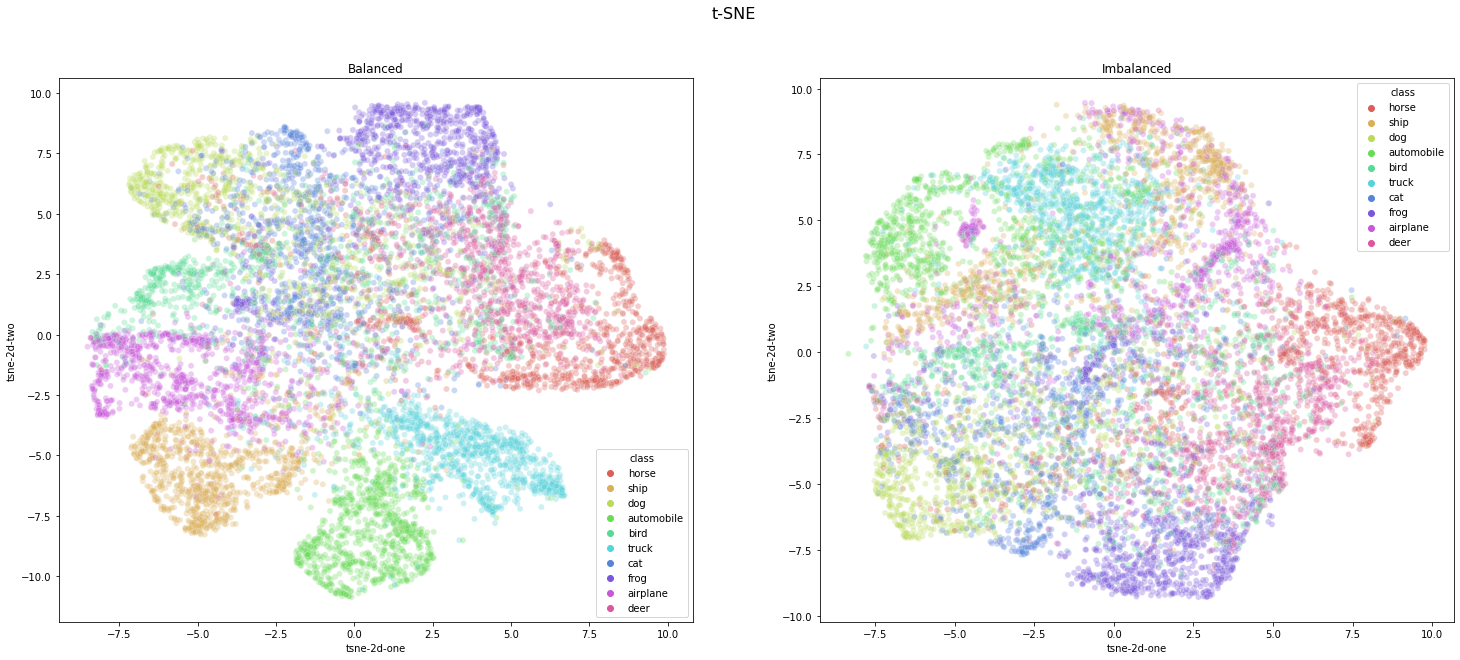

In [272]:
f = plt.figure(figsize=(25,10))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",# "y", # "ybin"
    palette=sns.color_palette("hls", 10), # 2
    data=df_bal.loc[rndperm,:],
    legend="full",
    alpha=0.3,
    ax = ax1
)
ax1.set_title('Balanced')
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",# "y", # "ybin"
    palette=sns.color_palette("hls", 10), # 2
    data=df_imb.loc[rndperm,:],
    legend="full",
    alpha=0.3,
    ax = ax2
)
ax2.set_title('Imbalanced')
f.suptitle('t-SNE', fontsize=16)

f.show()

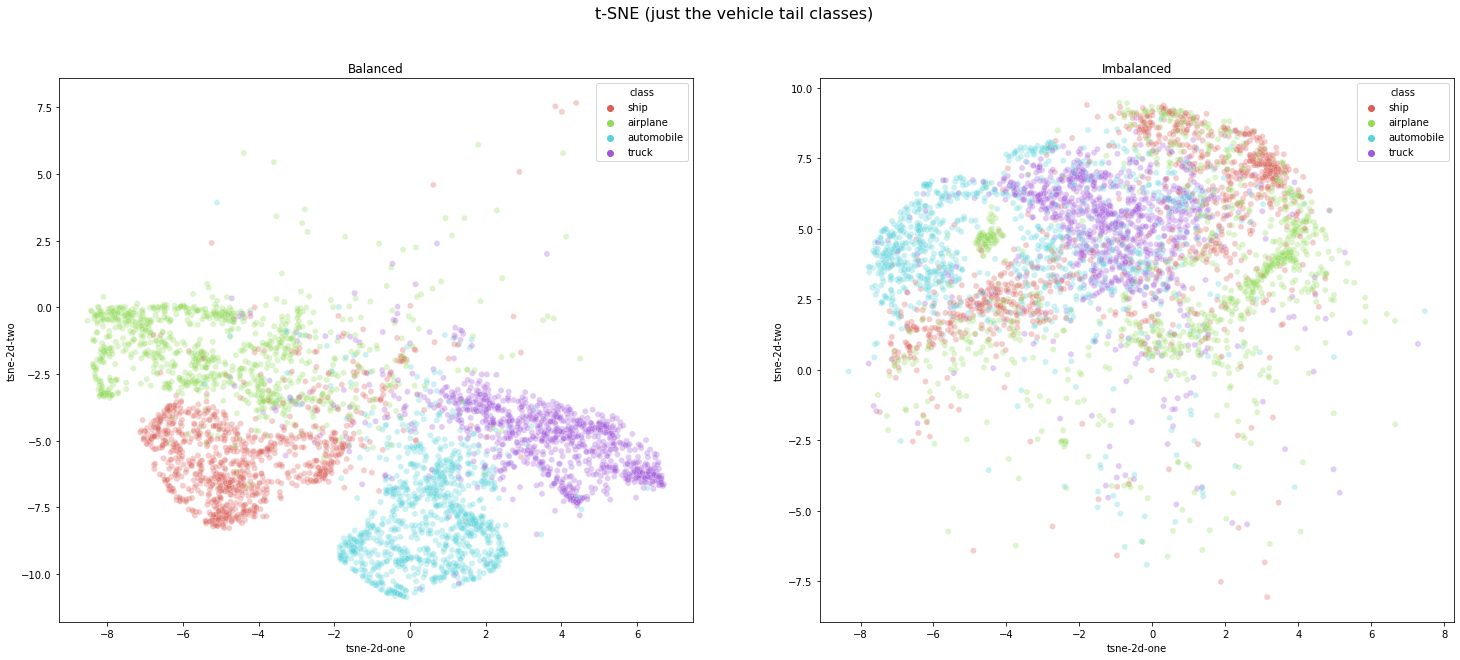

In [229]:
f = plt.figure(figsize=(25,10))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",# "y", # "ybin"
    palette=sns.color_palette("hls", 4), # 2
    data=df_bal[df_bal.ybin==1], #df_bal.loc[rndperm,:],
    legend="full",
    alpha=0.3,
    ax = ax1
)
ax1.set_title('Balanced')
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",# "y", # "ybin"
    palette=sns.color_palette("hls", 4), # 2
    data= df_imb[df_imb.ybin==1], #df_imb.loc[rndperm,:],
    legend="full",
    alpha=0.3,
    ax = ax2
)
ax2.set_title('Imbalanced')
f.suptitle('t-SNE (just the vehicle tail classes)', fontsize=16)

f.show()

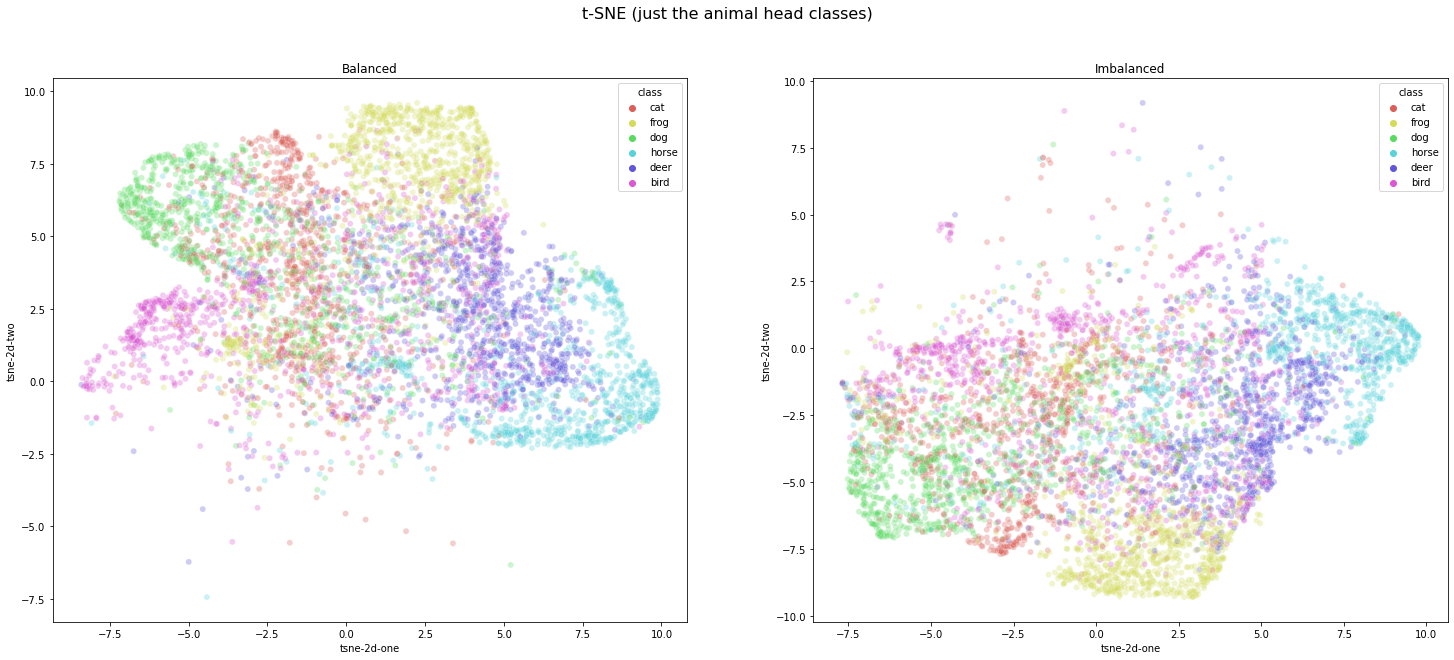

In [279]:
f = plt.figure(figsize=(25,10))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",# "y", # "ybin"
    palette=sns.color_palette("hls", 6), # 2
    data=df_bal[df_bal.ybin==0], #df_bal.loc[rndperm,:],
    legend="full",
    alpha=0.3,
    ax = ax1
)
ax1.set_title('Balanced')
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",# "y", # "ybin"
    palette=sns.color_palette("hls", 6), # 2
    data= df_imb[df_imb.ybin==0], #df_imb.loc[rndperm,:],
    legend="full",
    alpha=0.3,
    ax = ax2
)
ax2.set_title('Imbalanced')
f.suptitle('t-SNE (just the animal head classes)', fontsize=16)

f.show()

In [273]:
df_bal.columns[-7:]

Index(['ybin', 'pca-one', 'pca-two', 'pca-three', 'tsne-2d-one', 'tsne-2d-two',
       'class'],
      dtype='object')

In [277]:
df_bal.groupby('class')[['pca-one', 'pca-two', 'pca-three', 'tsne-2d-one', 'tsne-2d-two']].var()

,pca-one,pca-two,pca-three,tsne-2d-one,tsne-2d-two
class,,,,,
airplane,15.046108,15.480149,6.753826,6.021951,2.329214
automobile,16.193684,45.193333,4.597715,1.632844,4.093756
bird,13.557604,23.896486,20.439255,17.890186,4.875512
cat,19.259720,35.583557,15.167973,5.006283,8.093068
deer,11.276994,21.661303,39.439476,6.433946,4.475489
dog,13.387794,48.586678,15.320690,11.752778,5.622383
frog,8.609318,17.781256,5.997123,6.051624,8.476351
horse,11.228230,17.034449,58.844635,14.781610,5.117773
ship,9.043624,19.074131,2.684080,3.390893,3.305685


In [276]:
df_imb.groupby('class')[['pca-one', 'pca-two', 'pca-three', 'tsne-2d-one', 'tsne-2d-two']].var()

,pca-one,pca-two,pca-three,tsne-2d-one,tsne-2d-two
class,,,,,
airplane,42.177940,15.743526,13.223778,10.806899,9.348076
automobile,39.044434,19.649170,12.797402,8.027626,5.068337
bird,61.107948,50.943226,35.221722,13.802029,8.451618
cat,62.226894,34.885818,31.536983,7.767886,7.561696
deer,47.405891,32.665409,57.816891,7.138619,5.983684
dog,63.408596,54.795246,26.299984,11.411958,4.210377
frog,38.175671,37.488243,31.174524,6.061300,9.527596
horse,41.355137,69.715408,68.065628,19.095610,4.544795
ship,36.713417,14.795212,9.666245,11.212113,9.057862


# Appendix

In [ ]:
# """
# source: https://github.com/Spijkervet/SimCLR
# """
# import torch
# import torch.nn as nn
# import torchvision
# from torchvision.models.resnet import Bottleneck, ResNet


# class SimCLR(nn.Module):
#     """
#     We opt for simplicity and adopt the commonly used ResNet (He et al., 2016) to obtain hi = f(x ̃i) = ResNet(x ̃i) where hi ∈ Rd is the output after the average pooling layer.
#     """

#     def __init__(self, encoder, projection_dim, n_features):
#         super(SimCLR, self).__init__()

#         self.encoder = encoder
#         self.n_features = n_features

#         # Replace the fc layer with an Identity function
#         self.encoder.fc = Identity()

#         # We use a MLP with one hidden layer to obtain z_i = g(h_i) = W(2)σ(W(1)h_i) where σ is a ReLU non-linearity.
#         self.projector = nn.Sequential(
#             nn.Linear(self.n_features, self.n_features, bias=False),
#             nn.ReLU(),
#             nn.Linear(self.n_features, projection_dim, bias=False),
#         )

#     def forward(self, x_i, x_j):
#         h_i = self.encoder(x_i)
#         h_j = self.encoder(x_j)

#         z_i = self.projector(h_i)
#         z_j = self.projector(h_j)
#         return h_i, h_j, z_i, z_j


# class Identity(nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()

#     def forward(self, x):
#         return x



# def modify_resnet_model(model, *, cifar_stem=True, v1=True):
#     """Modifies some layers of a given torchvision resnet model to
#     match the one used for the CIFAR-10 experiments in the SimCLR paper.

#     Parameters
#     ----------
#     model : ResNet
#         Instance of a torchvision ResNet model.
#     cifar_stem : bool
#         If True, adapt the network stem to handle the smaller CIFAR images, following
#         the SimCLR paper. Specifically, use a smaller 3x3 kernel and 1x1 strides in the
#         first convolution and remove the max pooling layer.
#     v1 : bool
#         If True, modify some convolution layers to follow the resnet specification of the
#         original paper (v1). torchvision's resnet is v1.5 so to revert to v1 we switch the
#         strides between the first 1x1 and following 3x3 convolution on the first bottleneck
#         block of each of the 2nd, 3rd and 4th layers.

#     Returns
#     -------
#     Modified ResNet model.
#     """
#     assert isinstance(model, ResNet), "model must be a ResNet instance"
#     if cifar_stem:
#         conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         nn.init.kaiming_normal_(conv1.weight, mode="fan_out", nonlinearity="relu")
#         model.conv1 = conv1
#         model.maxpool = nn.Identity()
#     if v1:
#         for l in range(2, 5):
#             layer = getattr(model, "layer{}".format(l))
#             block = list(layer.children())[0]
#             if isinstance(block, Bottleneck):
#                 assert block.conv1.kernel_size == (1, 1) and block.conv1.stride == (
#                     1,
#                     1,
#                 )
#                 assert block.conv2.kernel_size == (3, 3) and block.conv2.stride == (
#                     2,
#                     2,
#                 )
#                 assert block.conv2.dilation == (
#                     1,
#                     1,
#                 ), "Currently, only models with dilation=1 are supported"
#                 block.conv1.stride = (2, 2)
#                 block.conv2.stride = (1, 1)
#     return model


# # You can check the architecture with the following snippet
# # from torchsummary import summary
# # from torchvision.models import resnet50
# # summary(modify_resnet_model(resnet50(num_classes=10)), (3, 32, 32))
# def get_resnet(name, pretrained=False):
#     resnets = {
#         "resnet18": torchvision.models.resnet18(pretrained=pretrained),
#         "resnet50": torchvision.models.resnet50(pretrained=pretrained),
#     }
#     if name not in resnets.keys():
#         raise KeyError(f"{name} is not a valid ResNet version")
#     return resnets[name]
